In [ ]:
import pandas as pd
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import asyncio
import csv
import os
from playwright.async_api import async_playwright

In [ ]:
output_path = os.path.expanduser("C:/Users/Tarik/OneDrive/Desktop/projetcookiza/movies.csv")
base_url = "https://www.themoviedb.org"
start_url = f"{base_url}/movie"
sleep_time = 3000  # en millisecondes

async def extract():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        context = await browser.new_context()
        page = await context.new_page()

        movie_links = set()
        page_number = 1

        while len(movie_links) < 1000 and page_number <= 100:
            print(f"Scraping page {page_number}...")
            await page.goto(f"{start_url}?page={page_number}")
            await page.wait_for_timeout(sleep_time)

            elements = await page.locator("div.card.style_1 a.image").all()
            for element in elements:
                href = await element.get_attribute("href")
                if href and href.startswith("/movie/"):
                    movie_links.add(href)

            page_number += 1

        print(f"{len(movie_links)} liens uniques récupérés.")

        movies = []
        for i, link in enumerate(list(movie_links)):
            movie_url = f"{base_url}{link}"
            try:
                await page.goto(movie_url)
                await page.wait_for_timeout(sleep_time)
            except Exception as e:
                print(f"Échec du chargement de {movie_url} : {e}")
                continue

            try:
                title = await page.locator("div.title h2 a").text_content()
                genres = await page.locator("span.genres a").all_text_contents()
                movies.append({
                    "title": title.strip() if title else None,
                    "genres": ", ".join([g.strip() for g in genres])
                })
                print(f"[{i+1}] {title}")

            except Exception as e:
                print(f"Erreur pour {movie_url}: {e}")

        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        with open(output_path, "w", newline='', encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=["title", "genres"])
            writer.writeheader()
            writer.writerows(movies)

        await browser.close()

asyncio.run(extract())

In [ ]:
def transform():   
    df = pd.read_csv("C:/Users/merya/OneDrive/Bureau/movies.csv")
    df.drop_duplicates()
    df['genres'] = df['genres'].str.replace(" ", "")
    genre_binaire = df["genres"].str.get_dummies(",")
    df = pd.concat([df.drop('genres', axis=1), genre_binaire], axis=1)
    df.to_csv("C:/Users/merya/OneDrive/Bureau/moviestransform.csv", index=False)
transform()

In [ ]:
df=pd.read_csv("C:/Users/Tarik/Downloads/moviestransform.csv")
movie_names = df.iloc[:, 0]    
genre_data = df.iloc[:, 1:]   
print(movie_names.head())
print(genre_data.head())
genre_data.info()
genre_data.shape

0                   9
1                1917
2            10 Lives
3               10x10
4    12 Years a Slave
Name: title, dtype: object
   Action  Adventure  Animation  Comedy  Crime  Documentary  Drama  Family  \
0       1          1          1       0      0            0      0       0   
1       0          0          0       0      0            0      1       0   
2       0          0          1       1      0            0      0       1   
3       0          0          0       0      0            0      1       0   
4       0          0          0       0      0            0      1       0   

   Fantasy  History  Horror  Music  Mystery  Romance  ScienceFiction  TVMovie  \
0        0        0       0      0        0        0               1        0   
1        0        1       0      0        0        0               0        0   
2        1        0       0      0        0        0               0        0   
3        0        0       0      0        1        0               0  

(999, 19)

In [39]:
missing_values=genre_data.isna().mean().sort_values(ascending=False)
print(missing_values)

Action            0.0
Horror            0.0
War               0.0
Thriller          0.0
TVMovie           0.0
ScienceFiction    0.0
Romance           0.0
Mystery           0.0
Music             0.0
History           0.0
Adventure         0.0
Fantasy           0.0
Family            0.0
Drama             0.0
Documentary       0.0
Crime             0.0
Comedy            0.0
Animation         0.0
Western           0.0
dtype: float64


Action            int64
Adventure         int64
Animation         int64
Comedy            int64
Crime             int64
Documentary       int64
Drama             int64
Family            int64
Fantasy           int64
History           int64
Horror            int64
Music             int64
Mystery           int64
Romance           int64
ScienceFiction    int64
TVMovie           int64
Thriller          int64
War               int64
Western           int64
dtype: object


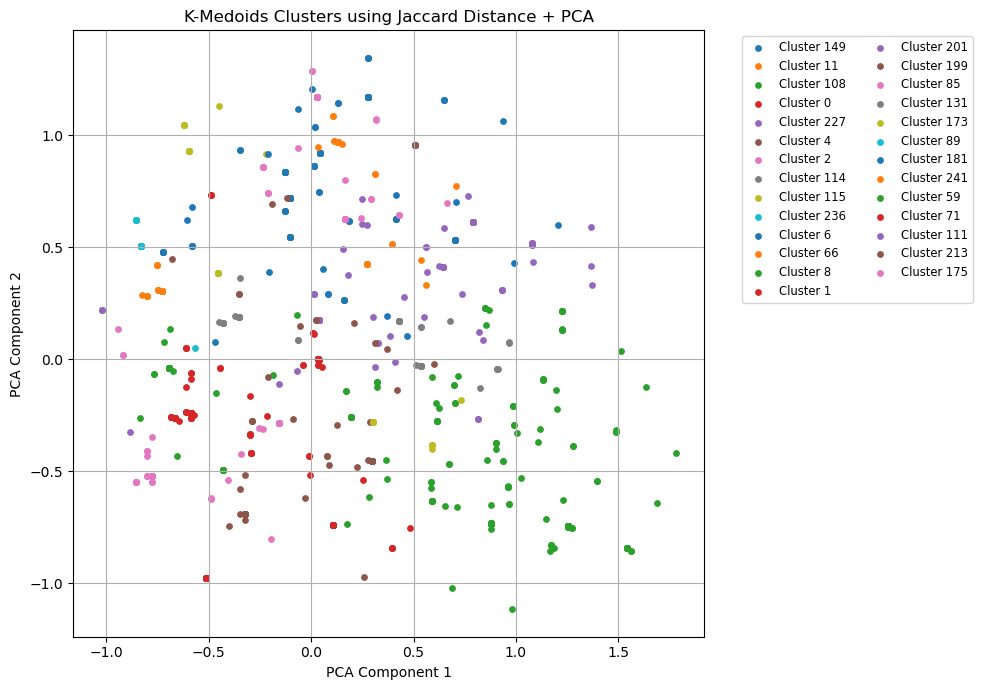


 The cluster for '10 Lives' contains 139 movies — generating dendrogram...


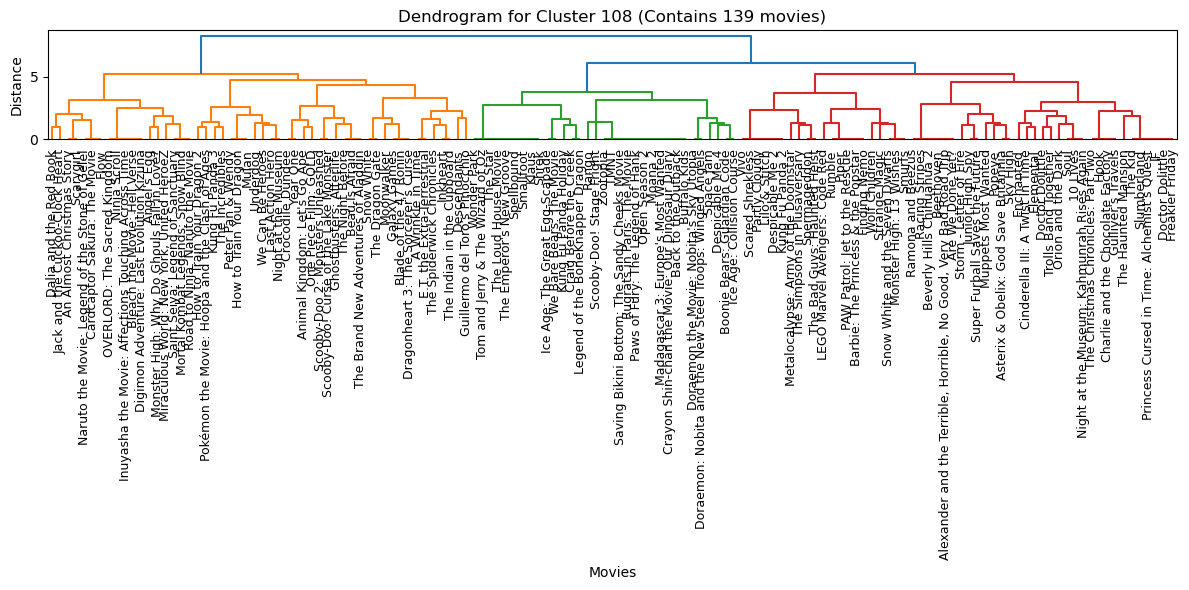


 Top 5 most similar movies to '10 Lives' in the same cluster:
 1. Night at the Museum: Kahmunrah Rises Again (distance: 0.0000)
 2. Soul (distance: 0.0000)
 3. IF (distance: 1.0000)
 4. Smallfoot (distance: 1.0000)
 5. Slumberland (distance: 1.0000)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

print(genre_data.dtypes)
distance_matrix = pairwise_distances(genre_data.values.astype(bool), metric='jaccard')
kmedoids = KMedoids(n_clusters=250, metric='precomputed', random_state=42)
df['Cluster'] = kmedoids.fit_predict(distance_matrix)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(genre_data)
df['PCA1'] = pca_data[:, 0]
df['PCA2'] = pca_data[:, 1]
plt.figure(figsize=(10, 7))
for cluster in df['Cluster'].unique():
    clustered = df[df['Cluster'] == cluster]
    plt.scatter(clustered['PCA1'], clustered['PCA2'], label=f'Cluster {cluster}', s=15)
plt.title('K-Medoids Clusters using Jaccard Distance + PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()
df_features = genre_data
def show_cluster_movies(movie_title):
    if movie_title not in df['title'].values:
        print(f" Movie '{movie_title}' not found in dataset.")
        return

    movie_cluster = df.loc[df['title'] == movie_title, 'Cluster'].values[0]
    cluster_size = (df['Cluster'] == movie_cluster).sum()

    if cluster_size <= 5:
        print(f"\n✅ The movie '{movie_title}' is in Cluster {movie_cluster}.")
        print(f"\n🎬 Other movies in the same cluster:")
        for title in df[df['Cluster'] == movie_cluster]['title'].tolist():
            print(f" - {title}")
    else:
        print(f"\n The cluster for '{movie_title}' contains {cluster_size} movies — generating dendrogram...")
        cluster_df = df[df['Cluster'] == movie_cluster]
        cluster_titles = cluster_df['title'].values
        cluster_features = df_features.loc[cluster_df.index].values
        linked = linkage(cluster_features, method='ward')
        plt.figure(figsize=(12, 6))
        dendrogram(linked, labels=cluster_titles, leaf_rotation=90, leaf_font_size=9)
        plt.title(f"Dendrogram for Cluster {movie_cluster} (Contains {cluster_size} movies)")
        plt.xlabel("Movies")
        plt.ylabel("Distance")
        plt.tight_layout()
        plt.show()
        movie_idx = cluster_df[cluster_df['title'] == movie_title].index[0]
        movie_index_within_cluster = cluster_df.index.get_loc(movie_idx)

        pairwise_dist = squareform(pdist(cluster_features, metric='euclidean'))
        distances = pairwise_dist[movie_index_within_cluster]

        closest_indices = np.argsort(distances)[1:6]
        closest_movie_titles = cluster_titles[closest_indices]

        print(f"\n Top 5 most similar movies to '{movie_title}' in the same cluster:")
        for i, title in enumerate(closest_movie_titles):
            print(f" {i+1}. {title} (distance: {distances[closest_indices[i]]:.4f})")

show_cluster_movies('10 Lives')